# Predicting Football Results with Statistical Modelling

Following [David Sheehan's](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/) iconic post, I'm adapting the [Dixon-Coles](http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf) model for the Greek Superleague.

## Data

We are using a single season of the Greek Superleague from [football-data.co.uk](football-data.co.uk). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
from scipy.optimize import minimize

gr1 = pd.read_csv("data\G12024.csv")


In [2]:
gr1 = gr1[['HomeTeam','AwayTeam','FTHG','FTAG']]
gr1 = gr1.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
gr1.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Volos NFC,Lamia,2,2
1,Giannina,Kifisia,3,0
2,OFI Crete,Aris,3,2
3,PAOK,Asteras Tripolis,3,0
4,Olympiakos,Panserraikos,2,0


In [3]:
gr1["HomeGoals"].mean()

np.float64(1.6541666666666666)

In [4]:
gr1["AwayGoals"].mean()

np.float64(1.3041666666666667)

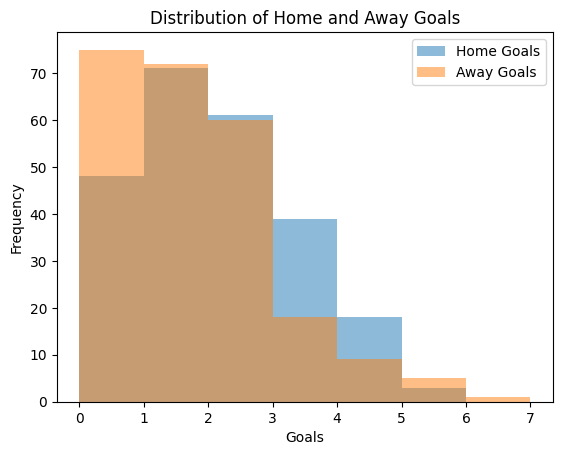

In [5]:
plt.hist(gr1["HomeGoals"], bins=range(0, gr1["HomeGoals"].max() + 2), alpha=0.5, label="Home Goals")
plt.hist(gr1["AwayGoals"], bins=range(0, gr1["AwayGoals"].max() + 2), alpha=0.5, label="Away Goals")
plt.xlabel("Goals")
plt.ylabel("Frequency")
plt.title("Distribution of Home and Away Goals")
plt.legend()
plt.show()


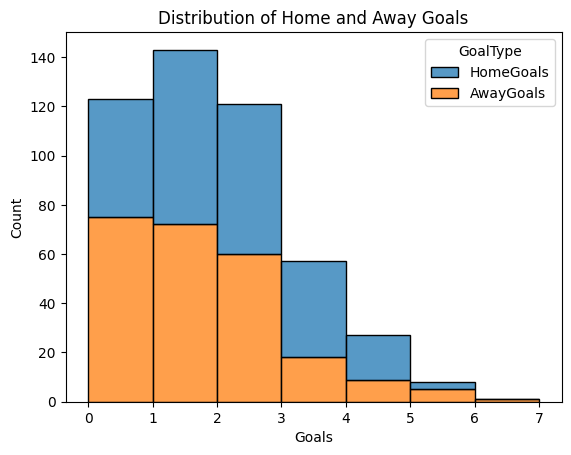

In [6]:
import seaborn as sns

# Melt the DataFrame for easier plotting
melted_df = gr1.melt(value_vars=["HomeGoals", "AwayGoals"], 
                    var_name="GoalType", value_name="Goals")

# Plot using seaborn
sns.histplot(data=melted_df, x="Goals", hue="GoalType", multiple="stack", bins=range(0, melted_df["Goals"].max() + 2))
plt.title("Distribution of Home and Away Goals")
plt.show()


### The Skellam distribution is the probability distribution of the difference between two Poisson-distributed random variables, which in this case allows us to estimate the final result based on the difference between home goals and away goals.

In [7]:
home_mean = gr1["HomeGoals"].mean()
away_mean = gr1["AwayGoals"].mean()

# Probability of a draw using the Skellam distribution
prob_draw = skellam.pmf(0, home_mean, away_mean)
print(f"Probability of a draw: {prob_draw}")

Probability of a draw: 0.24087962752358325


## Basic Poisson Model


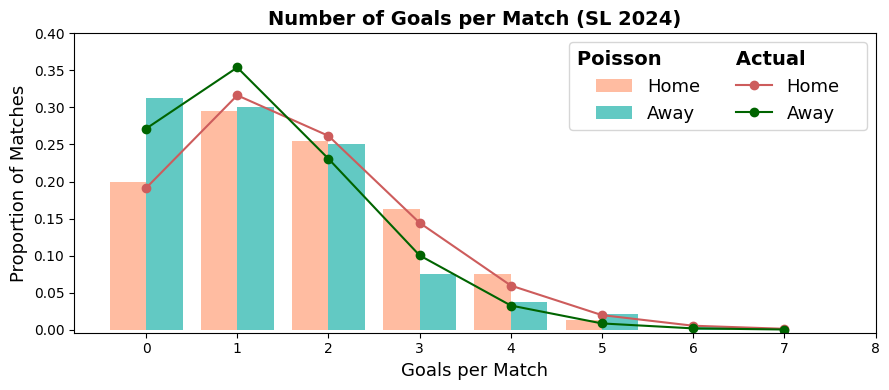

In [8]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([
    [poisson.pmf(i, home_mean) for i in range(8)],  # Poisson distribution for HomeGoals
    [poisson.pmf(i, away_mean) for i in range(8)]   # Poisson distribution for AwayGoals
])



fig, ax = plt.subplots(figsize=(9,4))  
# plot histogram of actual goals
plt.hist(gr1[['HomeGoals', 'AwayGoals']].values, range(9), density=True,
         alpha=0.7, label=['Home', 'Away'], color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i + 0.5 for i in range(0,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (SL 2024)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

In [9]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([gr1[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           gr1[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  480
Model:                            GLM   Df Residuals:                      452
Model Family:                 Poisson   Df Model:                           27
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -670.36
Date:                Wed, 20 Nov 2024   Deviance:                       448.24
Time:                        11:11:02   Pearson chi2:                     374.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2786
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [10]:
poisson_model.predict(pd.DataFrame(data={'team': 'Aris', 'opponent': 'PAOK',
                                       'home':1},index=[1]))

1    1.009682
dtype: float64

In [11]:
poisson_model.predict(pd.DataFrame(data={'team': 'PAOK', 'opponent': 'Aris',
                                       'home':0},index=[1]))

1    1.618276
dtype: float64

As an example, Aris is playing PAOK at home. We simulate the match and deduct probabilities for exact scores.

In [12]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
aris_paok = simulate_match(poisson_model, 'Aris', 'PAOK', max_goals=10)
print(aris_paok[0:5, 0:5])

[[0.07222581 0.11688126 0.09457304 0.05101508 0.02063911]
 [0.07292512 0.11801294 0.09548873 0.05150902 0.02083895]
 [0.0368156  0.05957779 0.04820664 0.02600387 0.01052036]
 [0.01239069 0.02005154 0.01622446 0.00875188 0.00354074]
 [0.00312766 0.00506142 0.00409539 0.00220916 0.00089376]]


In [15]:
def rho_correction(x, y, lambda_x, mu_y, rho):
    if x==0 and y==0:
        return 1- (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0

In [16]:
def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
            np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

In [17]:
def solve_parameters(dataset, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("Something's not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0, 1.0]) # rho (score correction), gamma (home advantage)
                                     ))
    def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like(row.HomeGoals, row.AwayGoals, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                     score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], rho, gamma) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints, **kwargs)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x)) 

In [18]:
params = solve_parameters(gr1)

C:\Users\Mitsos\AppData\Local\Temp\ipykernel_27036\744053136.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))
C:\Users\Mitsos\AppData\Local\Temp\ipykernel_27036\744053136.py:17: RuntimeWarning: invalid value encountered in log
  return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) +


Optimization terminated successfully    (Exit mode 0)
            Current function value: 669.8405063663943
            Iterations: 38
            Function evaluations: 1235
            Gradient evaluations: 38


In [19]:
params

{'attack_AEK': np.float64(2.839302832512224),
 'attack_Aris': np.float64(2.4018195005308742),
 'attack_Asteras Tripolis': np.float64(2.1582513003666417),
 'attack_Atromitos': np.float64(2.0538665888464065),
 'attack_Giannina': np.float64(1.9915002420910228),
 'attack_Kifisia': np.float64(2.063404470595264),
 'attack_Lamia': np.float64(2.29989659988385),
 'attack_OFI Crete': np.float64(2.0553291432014165),
 'attack_Olympiakos': np.float64(2.812213330357575),
 'attack_PAOK': np.float64(2.9182776157649726),
 'attack_Panathinaikos': np.float64(2.865878764337937),
 'attack_Panetolikos': np.float64(2.043286245940924),
 'attack_Panserraikos': np.float64(2.0660625115956237),
 'attack_Volos NFC': np.float64(2.061543673093772),
 'defence_AEK': np.float64(-2.6207556410268746),
 'defence_Aris': np.float64(-2.4500859534761137),
 'defence_Asteras Tripolis': np.float64(-1.9678235334665326),
 'defence_Atromitos': np.float64(-1.9920269922289513),
 'defence_Giannina': np.float64(-1.8485212513271525),
 '

The optimal `rho` value (-0.1285) returned by the model fits quite nicely with the value (-0.13) given in the equivalent [opisthokonta blog post](https://opisthokonta.net/?p=890). We can now start making some predictions by constructing match score matrices based on these model parameters. This part is quite similar to BP model, except for the correction applied to the 0-0, 1-0, 0-1 and 1-1 matrix elements.

In [20]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_'+homeTeam] + param_dict['defence_'+awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_'+homeTeam] + param_dict['attack_'+awayTeam])]

def dixon_coles_simulate_match(params_dict, homeTeam, awayTeam, max_goals=10):
    team_avgs = calc_means(params_dict, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array([[rho_correction(home_goals, away_goals, team_avgs[0],
                                                   team_avgs[1], params['rho']) for away_goals in range(2)]
                                   for home_goals in range(2)])
    output_matrix[:2,:2] = output_matrix[:2,:2] * correction_matrix
    return output_matrix

In [21]:
aris_paok_dc = dixon_coles_simulate_match(params, 'Aris', 'PAOK', max_goals=10)

In [22]:
# [Simple Poisson, Dixon-Coles]
print("Aris Win")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.tril(x, -1)), [aris_paok, aris_paok_dc])))))
print("PAOK Win")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.triu(x, 1)), [aris_paok, aris_paok_dc])))))
print("Draw")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.diag(x)), [aris_paok, aris_paok_dc])))))

Aris Win
Basic Poisson: 0.23621; Dixon-Coles: 0.22898
PAOK Win
Basic Poisson: 0.51564; Dixon-Coles: 0.49729
Draw
Basic Poisson: 0.24815; Dixon-Coles: 0.27373


The purpose of the Dixon-Coles model is to correct the underesimation of Draws that is present in the simple Poisson model. In this case, it seems to work as expected, increasing the probability of Draws by 2 and a half points.

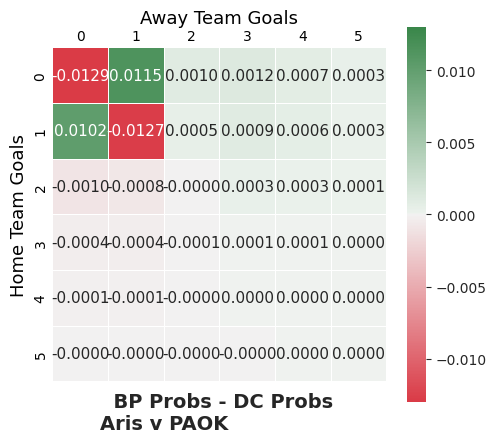

In [23]:
cmap = sns.diverging_palette(10, 133, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))    
with sns.axes_style("white"):
    ax = sns.heatmap(simulate_match(poisson_model, 'Aris', 'PAOK', max_goals=5) - \
                     dixon_coles_simulate_match(params, 'Aris', 'PAOK', max_goals=5), 
                     annot=True, fmt='.4f', cmap=cmap, vmin=-0.013, vmax=.013, center=0.00,
                     square=True, linewidths=.5, annot_kws={"size": 11}, cbar_kws={"shrink": .8})
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(which='major', axis='both', linestyle='')
    ax.set_xlabel('Away Team Goals', fontsize=13)
    ax.set_ylabel('Home Team Goals', fontsize=13)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    plt.figtext(0.45, 0.07, '  BP Probs - DC Probs \nAris v PAOK', horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi=0):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                              np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

In [25]:
gr1 = pd.read_csv("data\G12024.csv")
gr1['Date'] = pd.to_datetime(gr1['Date'],  format='%d/%m/%Y')
gr1['time_diff'] = (max(gr1['Date']) - gr1['Date']).dt.days
gr1 = gr1[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'time_diff']]
gr1 = gr1.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
gr1.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,FTR,time_diff
0,Volos NFC,Lamia,2,2,D,275
1,Giannina,Kifisia,3,0,H,273
2,OFI Crete,Aris,3,2,H,273
3,PAOK,Asteras Tripolis,3,0,H,273
4,Olympiakos,Panserraikos,2,0,H,273


In [26]:
def solve_parameters_decay(dataset, xi=0.001, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("something not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0,1.0]) # rho (score correction), gamma (home advantage)
                                     ))
        
    def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi=xi):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                                  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like_decay(row.HomeGoals, row.AwayGoals, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                                      score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], 
                                      rho, gamma, row.time_diff, xi=xi) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x)) 

In [27]:
params_xi= solve_parameters_decay(gr1, xi=0.0018)

C:\Users\Mitsos\AppData\Local\Temp\ipykernel_27036\1602507443.py:19: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))
C:\Users\Mitsos\AppData\Local\Temp\ipykernel_27036\1602507443.py:18: RuntimeWarning: invalid value encountered in log
  return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) +


Optimization terminated successfully    (Exit mode 0)
            Current function value: 530.8011855679218
            Iterations: 34
            Function evaluations: 1104
            Gradient evaluations: 34


In [73]:
params_xi

{'attack_AEK': np.float64(2.847487992347576),
 'attack_Aris': np.float64(2.403206161534189),
 'attack_Asteras Tripolis': np.float64(2.1256201253417997),
 'attack_Atromitos': np.float64(2.02208950813449),
 'attack_Giannina': np.float64(1.9879350372667814),
 'attack_Kifisia': np.float64(2.051831129106533),
 'attack_Lamia': np.float64(2.304384352887014),
 'attack_OFI Crete': np.float64(2.0590010290365726),
 'attack_Olympiakos': np.float64(2.8058479329474157),
 'attack_PAOK': np.float64(2.926559847340654),
 'attack_Panathinaikos': np.float64(2.844762799257246),
 'attack_Panetolikos': np.float64(2.062072842990206),
 'attack_Panserraikos': np.float64(2.0410764911304247),
 'attack_Volos NFC': np.float64(2.0651369051439414),
 'defence_AEK': np.float64(-2.6119999770213504),
 'defence_Aris': np.float64(-2.4513778671629955),
 'defence_Asteras Tripolis': np.float64(-1.9503577598223427),
 'defence_Atromitos': np.float64(-1.985327253280664),
 'defence_Giannina': np.float64(-1.8122171342151683),
 'de